## Libs

In [ ]:
# BiocManager::install("golubEsets")
# BiocManager::install("umap")


In [2]:
library(tidyr)
library(dplyr)
library(vegan)
library(ggplot2)
library(gridExtra)
library(ape)
library(pvclust)
library(golubEsets)
library(umap)
library(clusterProfiler)
library(boot)


## EDA

In [3]:
require(golubEsets)
data(Golub_Merge)
golub <- data.frame(Golub_Merge)[1:7129]


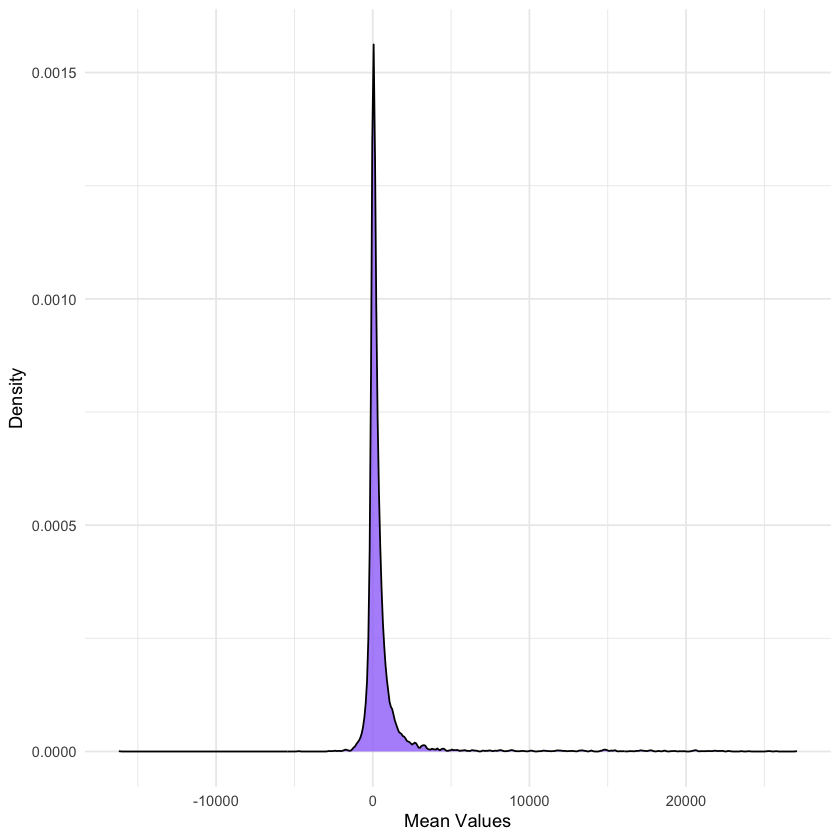

In [4]:
mean_values <- colMeans(golub)
mean_df <- data.frame(mean_values)

ggplot(mean_df, aes(x = mean_values)) +
  geom_density(fill = "#A076F9", alpha = 0.8) +
  labs(x = "Mean Values", y = "Density") +
  theme_minimal()


Data looks OK. It is centered around zero as was scaled prior to our analysis.

In [5]:
golub <- decostand(golub, method = "log", MARGIN = 2)


## Calculating distance measures

In [10]:
dist_manhattan <- vegdist(golub, method = "manhattan")
dist_euclidian <- vegdist(golub, method = "euclidean")
dist_canberra <- vegdist(golub, method = "canberra")

distances <- list(
    Manhattan = dist_manhattan,
    Euclidean = dist_euclidian,
    Canberra = dist_canberra
)


In [11]:
compare_clustering_methods <- function(distances, cluster_methods) {
    res_cof <- data.frame(
        Method = character(0),
        Distance = character(0),
        Corr = numeric(0)
    )

    for  (method in methods) {
        for (dist in names(distances)) {
            d <- distances[[dist]]
            hs <- hclust(d, method = method)
            ph <- as.phylo(hs)
            coph <- cophenetic(hs)
            corr <- cor(d, as.dist(coph))
            res_cof <- rbind(res_cof, data.frame(
                Method = method,
                Distance = dist,
                Correlation = corr
            ))

            status <- factor(Golub_Merge$ALL.AML, levels = c("AML", "ALL"))
            colors <- ifelse(status == "AML", "#F266AB", "#A076F9")
            plot(ph, type = "phylogram", main = paste("Distance:", dist, ", Clustering:", method), cex = 0.6, tip.color = colors)
        }
    }
    return(res_cof)
}


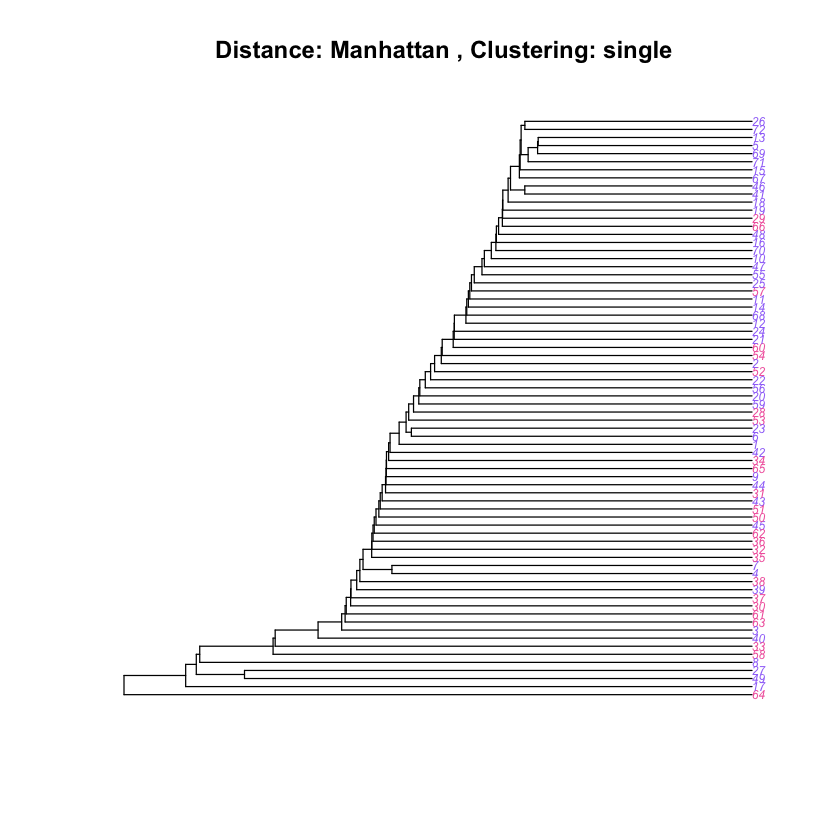

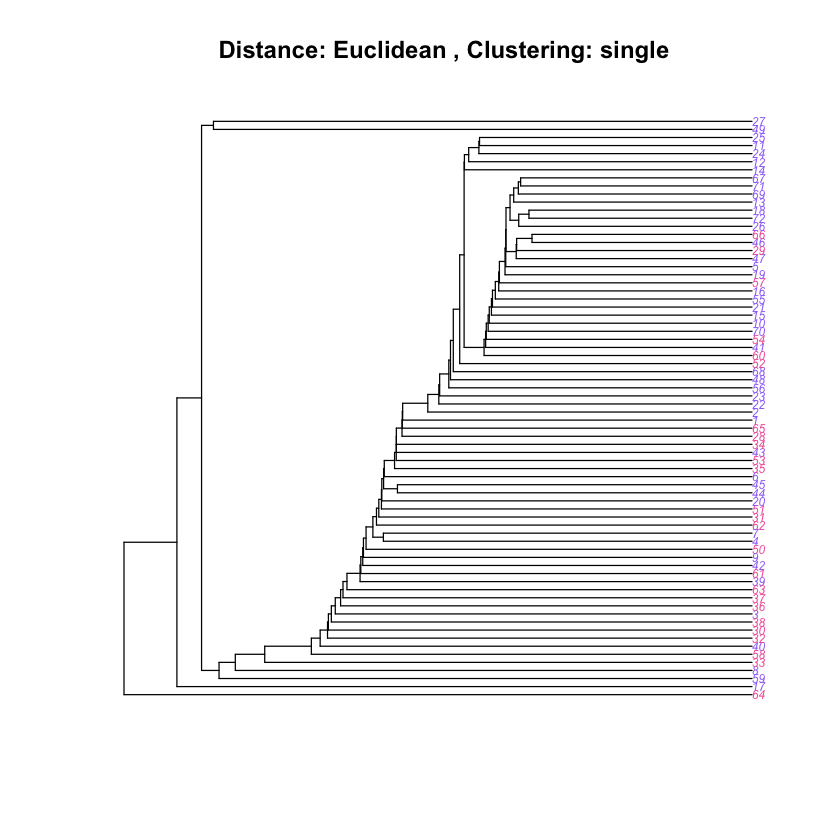

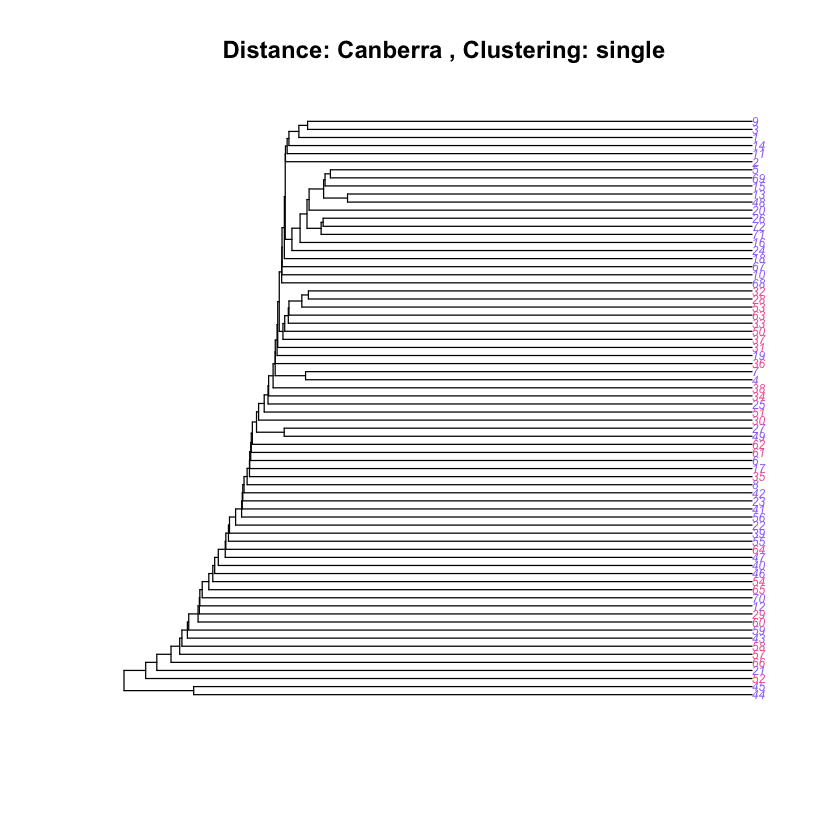

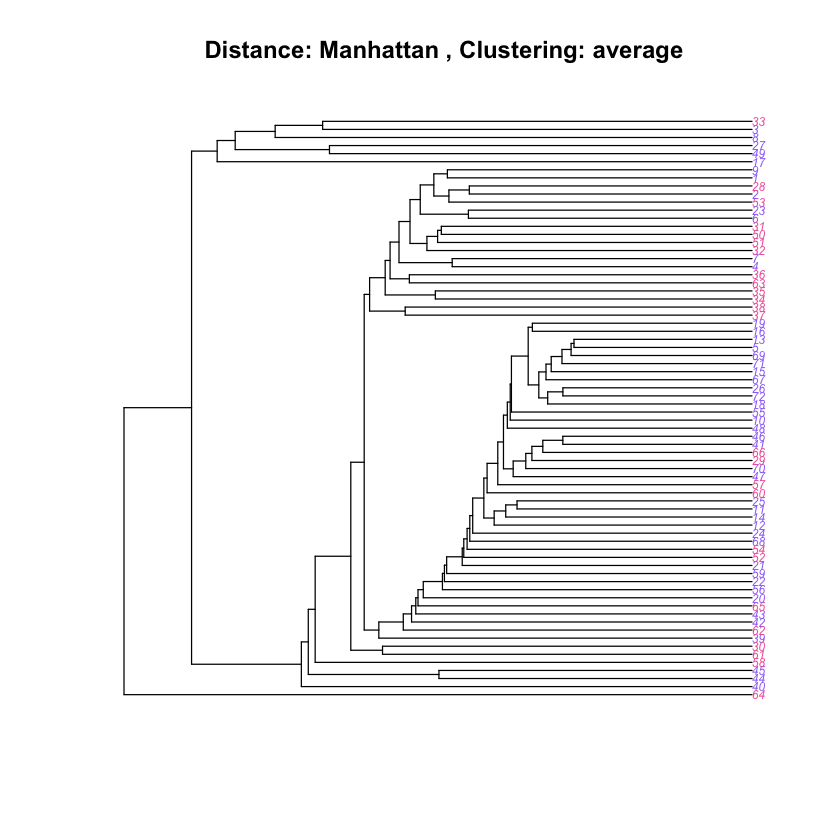

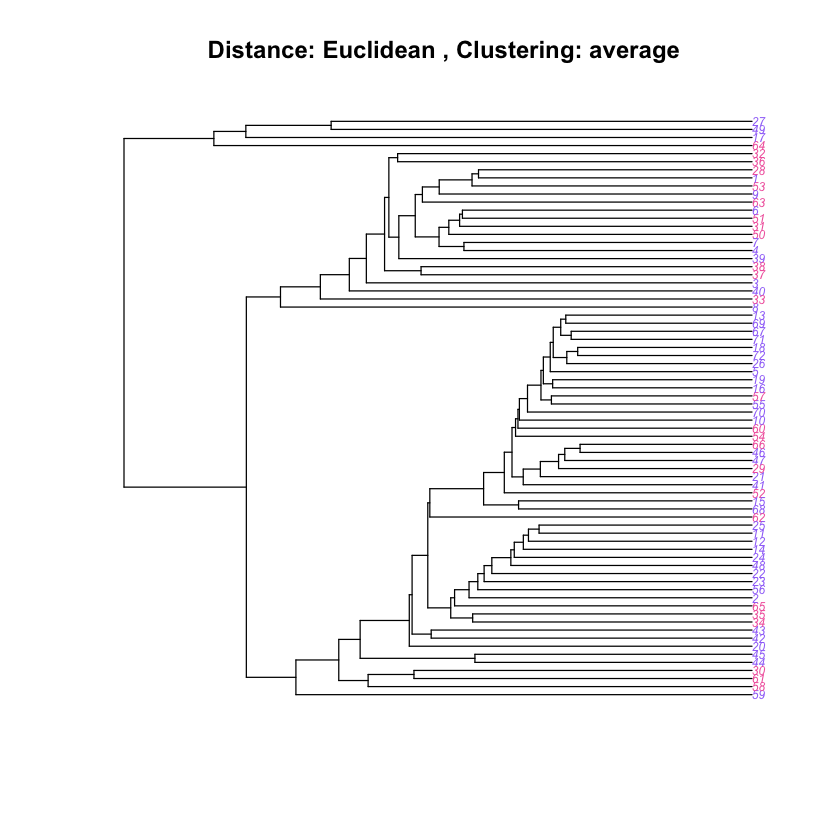

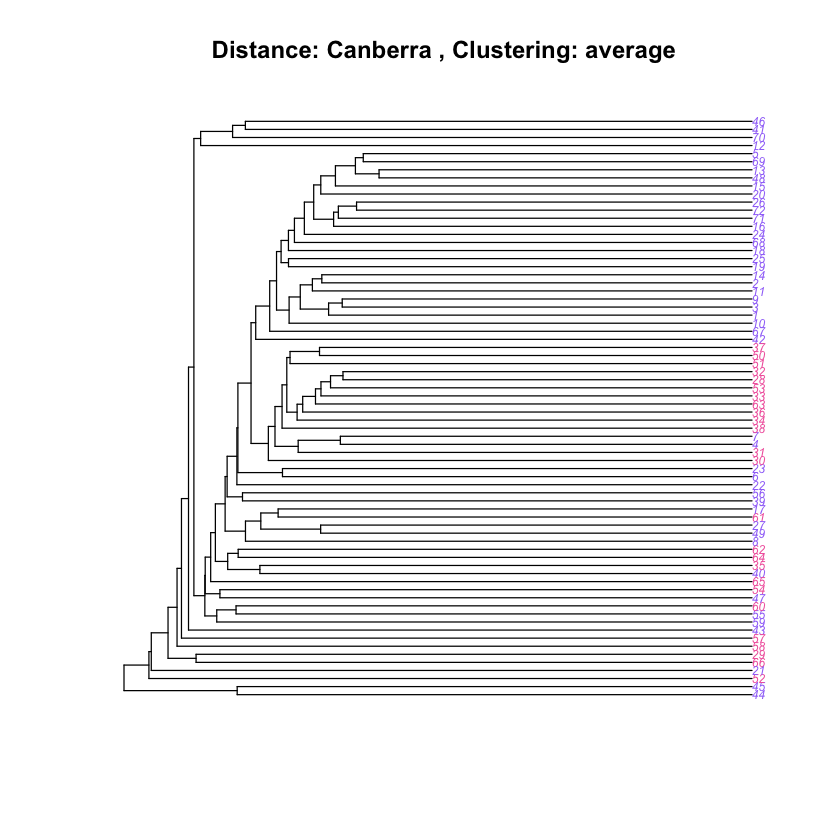

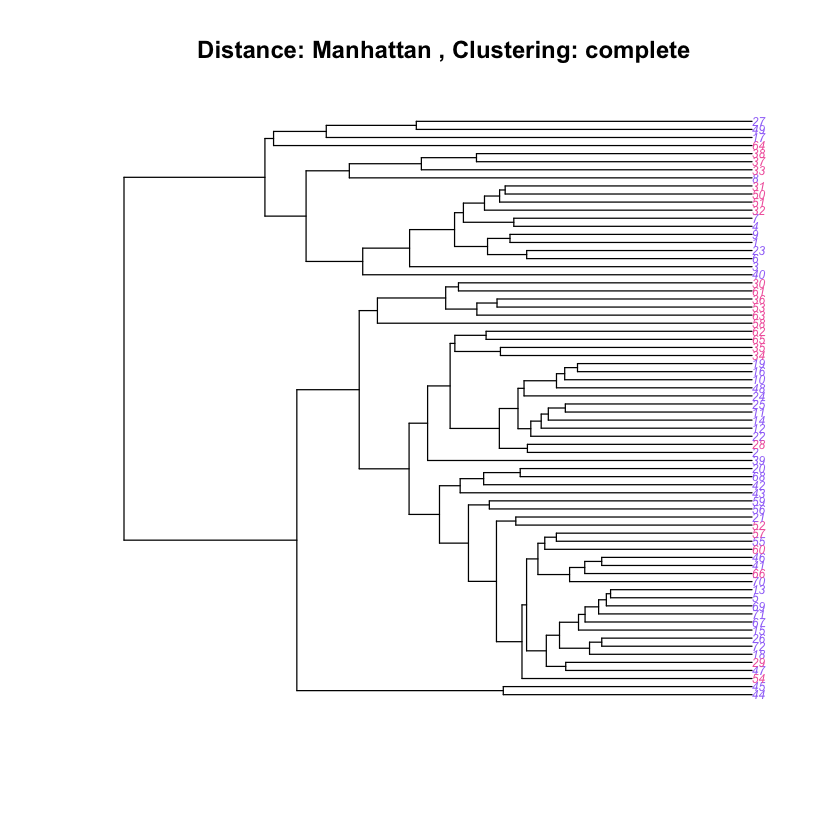

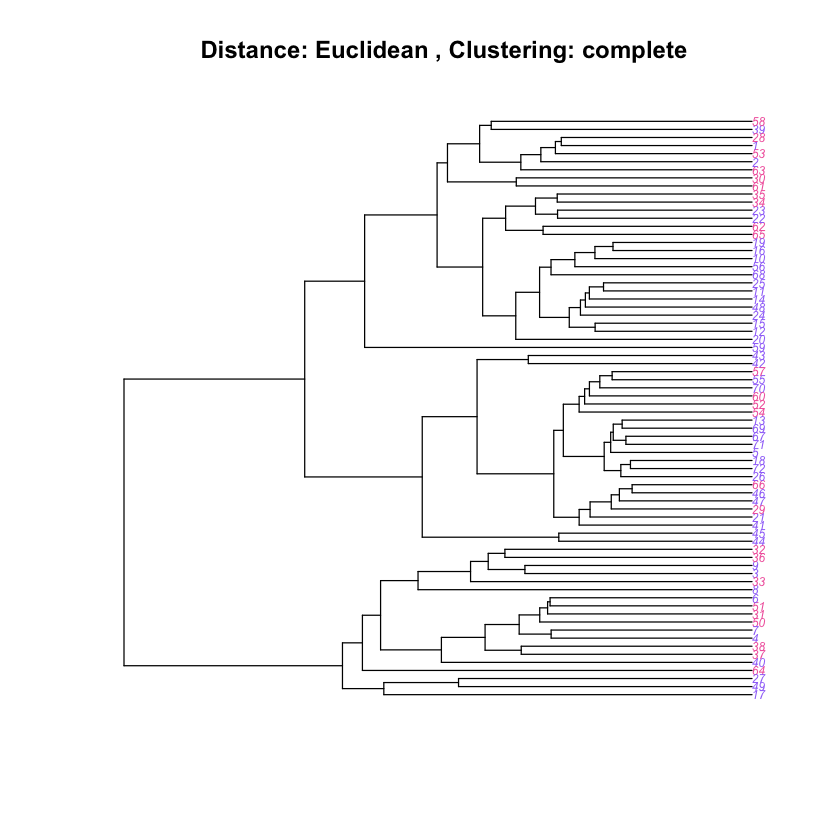

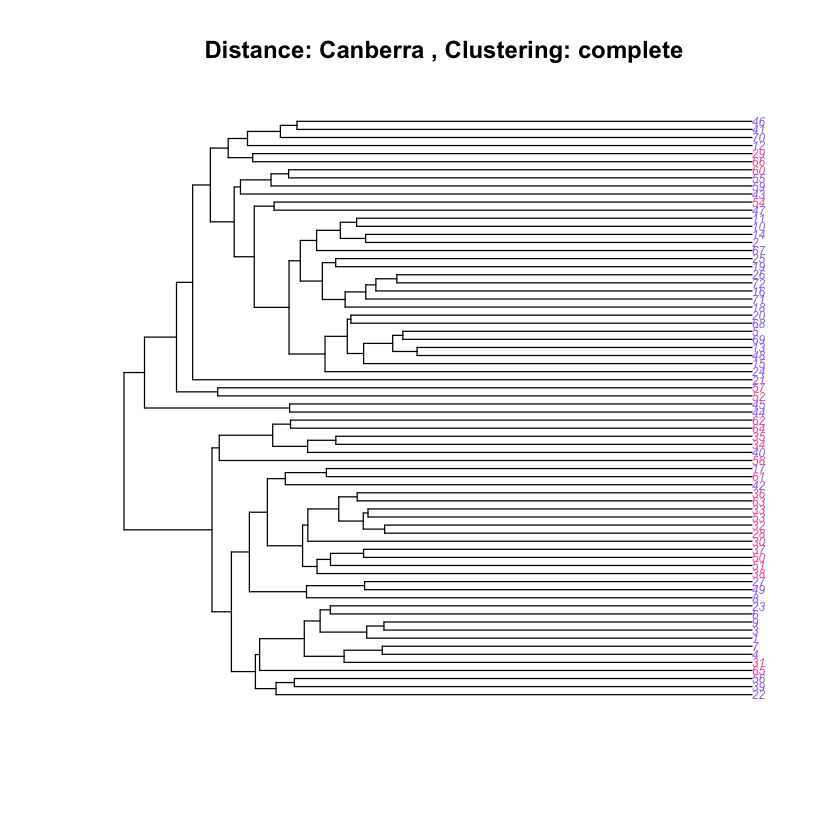

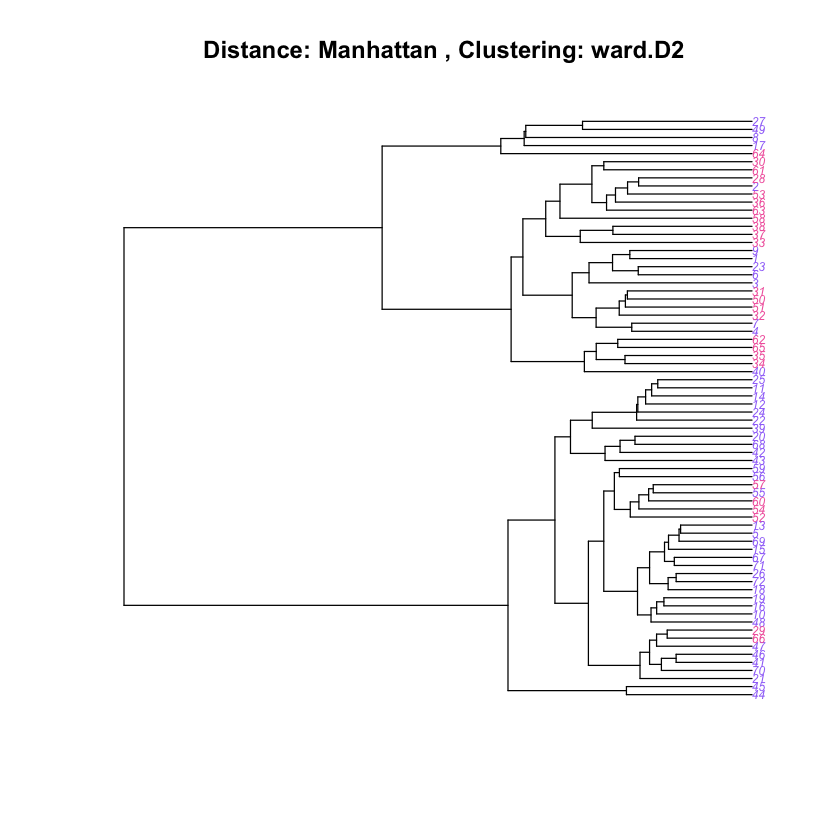

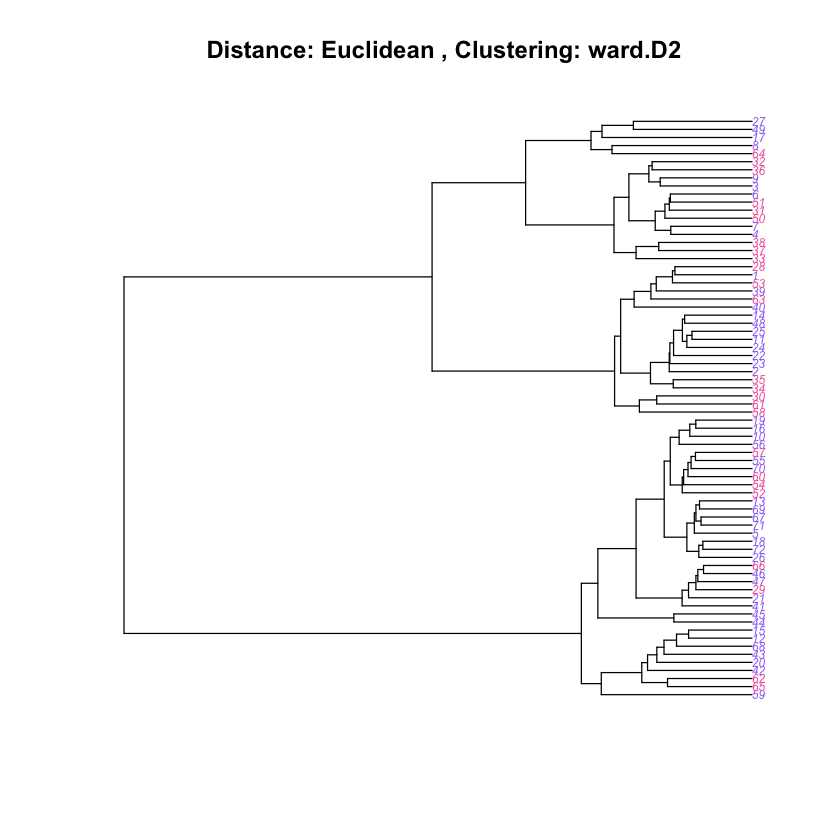

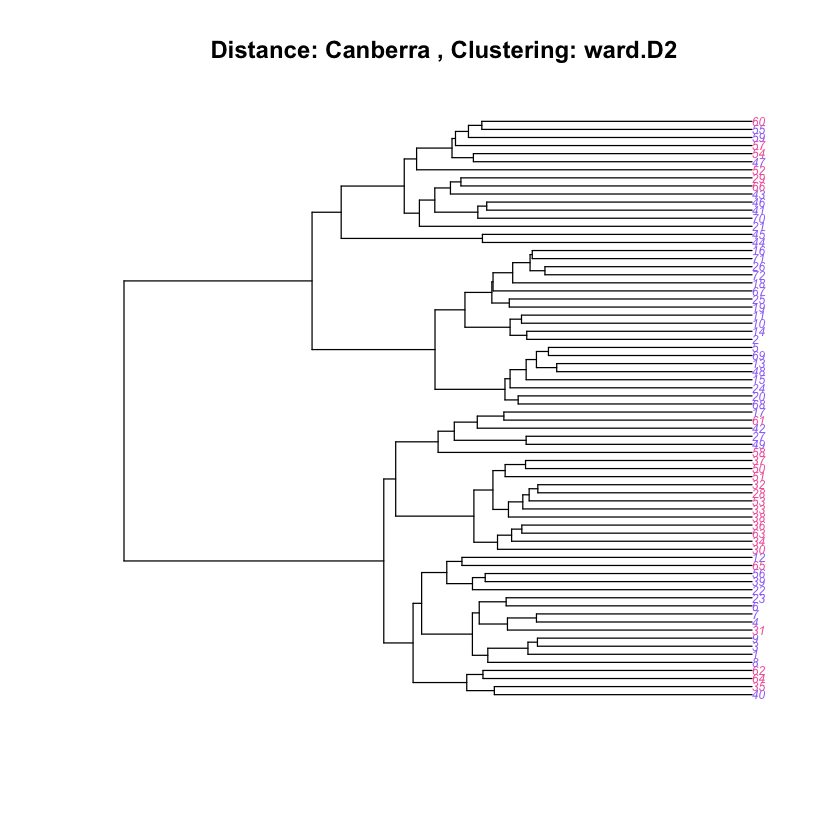

In [12]:
methods <- c("single", "average", "complete", "ward.D2")
comparison_df <- spread(compare_clustering_methods(distances, methods), Distance, Correlation)

comparison_df[["Mean"]] <- rowMeans(comparison_df[, 2:4])


In [13]:
comparison_df


Method,Canberra,Euclidean,Manhattan,Mean
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
average,0.8570437,0.8154784,0.9062389,0.8595870
complete,0.5346063,0.7154215,0.6683661,0.6394646
single,0.8251748,0.7639598,0.9056739,0.8316028
ward.D2,0.3971771,0.5727413,0.5333923,0.5011036


In [14]:
max_val <- max(comparison_df[, -1])
max_index <- which(comparison_df == max_val, arr.ind = TRUE)
row_name <- comparison_df[max_index[1], 1]
col_name <- colnames(comparison_df)[max_index[2]]

# Print column name, row name, and maximum value
cat("Column:", col_name, "\n")
cat("Row:", row_name, "\n")
cat("Value:", max_val, "\n")


Column: Manhattan 
Row: average 
Value: 0.9062389 


## Boostrap

In [15]:
bs_man_average <- pvclust(t(golub),
    method.dist = "manhattan",
    method.hclust = "average",
    nboot = 100,
    parallel = T,
    iseed = 42
)


Creating a temporary cluster...done:
socket cluster with 7 nodes on host 'localhost'
Multiscale bootstrap... Done.


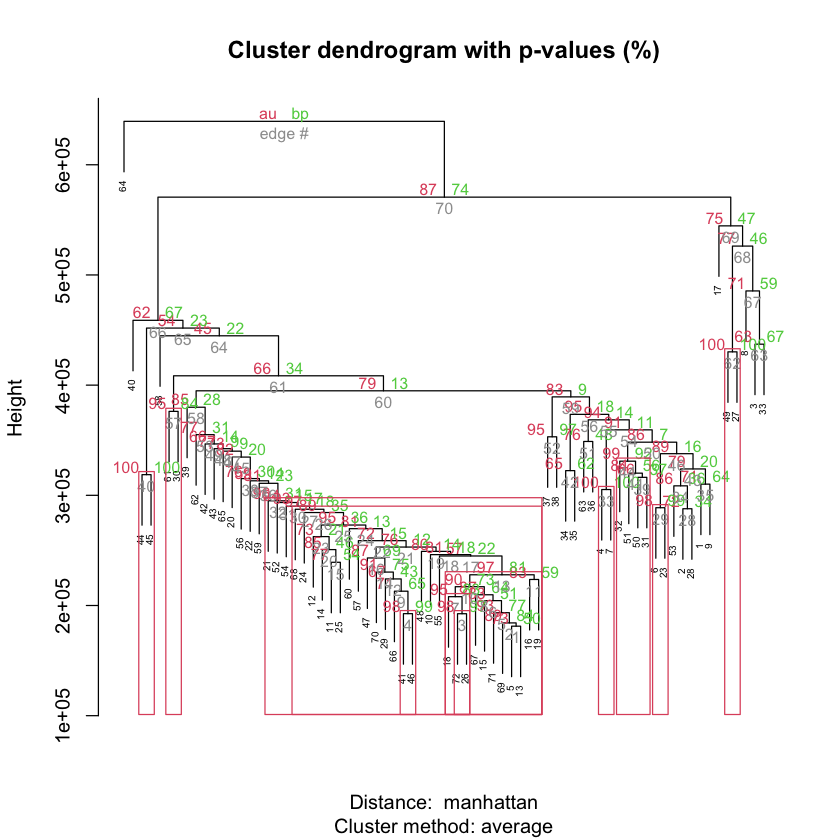

In [16]:
plot(bs_man_average, cex = 0.5)
pvrect(bs_man_average, alpha = 0.95, max.only = F)


In [17]:
bs_man_ward <- pvclust(t(golub),
    method.dist = "manhattan",
    method.hclust = "ward.D2",
    nboot = 100,
    parallel = T,
    iseed = 42
)


Creating a temporary cluster...done:
socket cluster with 7 nodes on host 'localhost'
Multiscale bootstrap... Done.


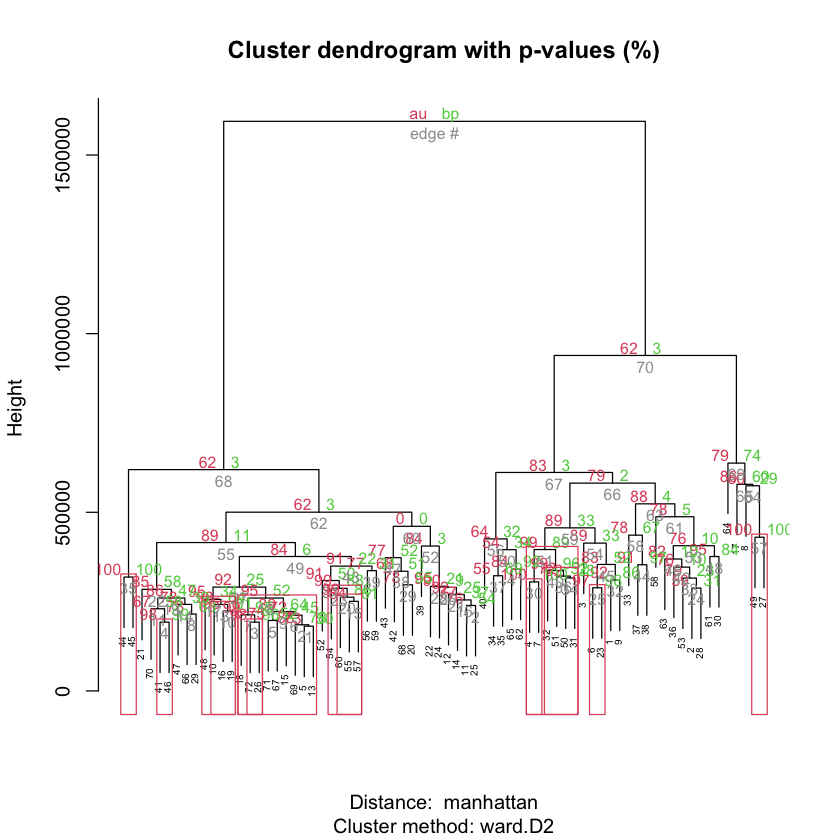

In [18]:
plot(bs_man_ward, cex = 0.5)
pvrect(bs_man_ward, alpha = 0.95, max.only = F)


PCA plot to make sure if batch effect persists

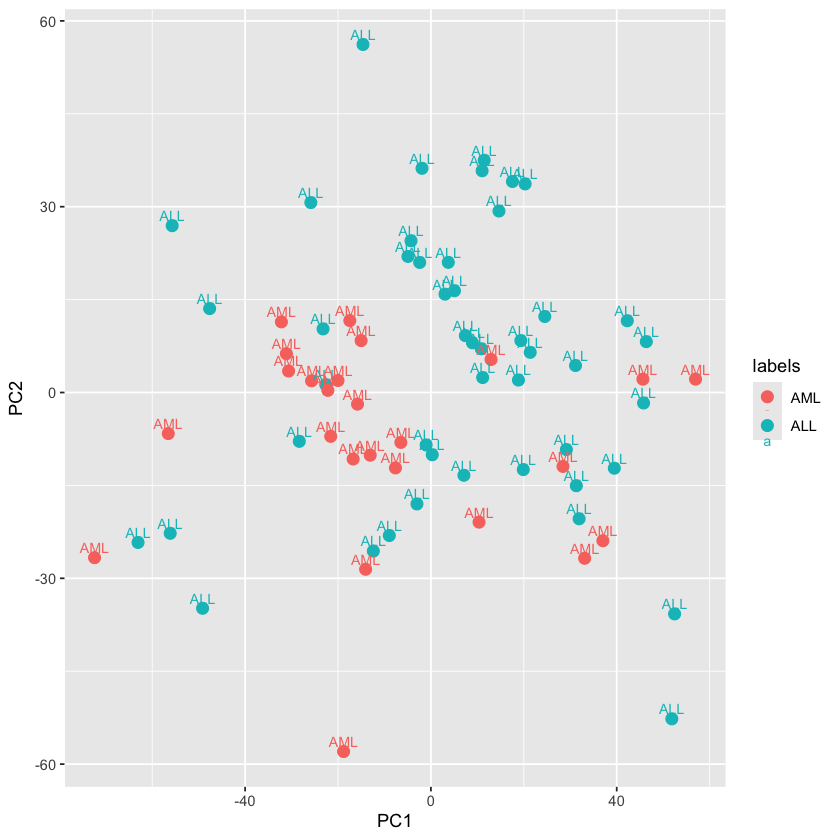

In [19]:
pca_result <- prcomp(golub, scale. = TRUE)
pca_df <- as.data.frame(pca_result$x)

pca_df$labels <- factor(Golub_Merge$ALL.AML, levels = c("AML", "ALL"))
ggplot(data = pca_df, aes(x = PC1, y = PC2, color = labels)) +
    geom_point(size = 3) +
    geom_text(aes(label = labels), size = 3, vjust = -0.5)


## Conclusions

- The best clustering and distance methods in terms of correlation score was Manhattan distance coupled with UPGMA clustering. However, by visual inspection the better-looking approach was Manhattan distance + ward.D2 clustering. 

- I applied boostrap to both above-mentioned methods, i.e. Manhattan distance + UPGMA/ward.D2. Both methods perform relatively poorly as there are no distinct statistically significant clusters related to AML and ALL groups. 

- Observed phenomena indicates the presence of possible batch effect, which is also supported by PCA analysis. Samples tend to group by not by the factor of biological interest in this study. Dendrograms typically display small clusters of two or three branches, which indicate influence of various factors not covered in this analysis. Possible solution can be inclusion of such factor in study design or outlier detection and removal prior to any further analysis to avoid bias resulting frow skewed data.